In [1]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from simple_fc import Encoder,Decoder
from cvae import Conditional_Variational_Autoencoder
from misc_ops import *

import numpy as np
import tensorflow as tf

from cs294_129.classifiers.pretrained_cnn import PretrainedCNN
from cs294_129.image_utils import preprocess_image#, blur_image, deprocess_image

from dataset import DataSet

from PIL import Image

from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
pre_trained_model = PretrainedCNN(h5_file='../networks/cs294_129/datasets/pretrained_model.h5')

In [4]:
x = mnist.train.images
y = mnist.train.labels
num_train = mnist.train.num_examples
mean_img = np.mean(x, axis=0)

In [5]:
x_rgb = np.zeros((num_train, 3, 64, 64))
for i in xrange(num_train):
    x_rgb[i,] = gray_to_rgb(x[i,]-mean_img)

In [9]:
batch_size = 1000
layer=3

In [7]:
feats, _ = pre_trained_model.forward(x_rgb[xrange(batch_size),], end=layer)

In [10]:
for i in xrange(1, num_train / batch_size):
    feats_curr, _ = pre_trained_model.forward(x_rgb[xrange(i*batch_size, (i+1)*batch_size),], end=layer)
    feats = np.concatenate((feats,feats_curr), axis=0)
    print i

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [11]:
print feats.shape

(55000, 128, 16, 16)


In [12]:
feats = feats.reshape((num_train, -1))
print feats.shape

(55000, 32768)


In [13]:
np.savez_compressed('mnist_feats_3', feats=feats)

In [14]:
feats = np.load('mnist_feats_3.npz')['feats']

In [15]:
xnew = np.concatenate((x, feats), axis=1)
feats_dat = DataSet(xnew, y, dtype=dtypes.float32, reshape=False)

In [18]:
img_dim = xnew.shape[1]

# Train (compute features on-the-fly)

In [72]:
tf.reset_default_graph()

In [42]:
# Training
"""
sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,img_dim = img_dim,dataset = mnist.train,
                                            learning_rate = 0.001, num_epochs = 10,
                                           condition_on_label=True, model=pre_trained_model, layer=3,
                                            checkpoint_name = 'cvae_feats_checkpoint')
model.train()
"""

Epoch 1 loss: 4033.4165989
Epoch 2 loss: 3578.95891335
Epoch 3 loss: 3521.36814409
Epoch 4 loss: 3488.95134322
Epoch 5 loss: 3466.49150879
Epoch 6 loss: 3450.35012873
Epoch 7 loss: 3437.64695091
Epoch 8 loss: 3427.97487749
Epoch 9 loss: 3420.0551598
Epoch 10 loss: 3413.45985174


In [73]:
# Load checkpoint
"""
sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,img_dim = img_dim,dataset = mnist.train,
                                            learning_rate = 0.001, num_epochs = 10,
                                           condition_on_label=True, model=pre_trained_model, layer=3,
                                            load = True, load_file = 'checkpoints/cvae_feats_checkpoint',
                                            checkpoint_name = 'cvae_feats_checkpoint2')
"""

In [75]:
#model.train()

Epoch 1 loss: 3421.26915882
Epoch 2 loss: 3372.89009544
Epoch 3 loss: 3363.16953658
Epoch 4 loss: 3356.64955922
Epoch 5 loss: 3351.46776056
Epoch 6 loss: 3347.13398437
Epoch 7 loss: 3343.33462447
Epoch 8 loss: 3340.22612482
Epoch 9 loss: 3337.42642001
Epoch 10 loss: 3334.76738059


# Train (features pre-computed)

In [45]:
tf.reset_default_graph()

In [26]:
# Training

sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,img_dim = img_dim,dataset = feats_dat,
                                            learning_rate = 0.005, num_epochs = 10,
                                           condition_on_label=True,
                                            checkpoint_name = 'cvae_feats_checkpoint')
model.train()


Epoch 1 loss: 3931.09440208
Epoch 2 loss: 3679.60061745
Epoch 3 loss: 3649.67454767
Epoch 4 loss: 3634.5153489
Epoch 5 loss: 3626.10800737
Epoch 6 loss: 3619.01209606
Epoch 7 loss: 3615.3037065
Epoch 8 loss: 3609.5842112
Epoch 9 loss: 3607.72683904
Epoch 10 loss: 3605.12089444


In [46]:
# Load checkpoint

sess = tf.InteractiveSession()
build_encoder = Encoder(200)
build_decoder = Decoder(200)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,img_dim = img_dim,dataset = feats_dat,
                                            learning_rate = 0.005, num_epochs = 10,
                                           condition_on_label=True,
                                            load = True, load_file = 'checkpoints/cvae_feats_checkpoint4',
                                            #checkpoint_name = 'cvae_feats_checkpoint4'
                                           )


In [42]:
#model.train()

Epoch 1 loss: 3608.14774148
Epoch 2 loss: 3596.07914773
Epoch 3 loss: 3592.70239435
Epoch 4 loss: 3591.21437855
Epoch 5 loss: 3591.33762429
Epoch 6 loss: 3589.16400036
Epoch 7 loss: 3588.42799805
Epoch 8 loss: 3588.44780051
Epoch 9 loss: 3586.77185902
Epoch 10 loss: 3586.45559659


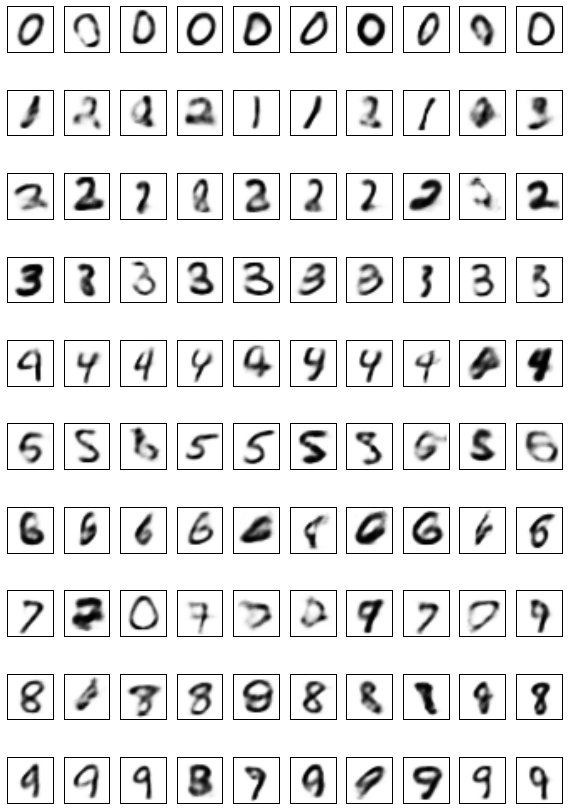

In [47]:
#images, info = mnist.test.next_batch(100)
num_examples = 10

info = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=100, info=info)
generated_images = generated_images[:, xrange(28*28)]

num_show = 5
plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig('images/by_label_feats')
plt.show()

In [ ]:
sess.close()
tf.reset_default_graph()